In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import numpy as np
#import utils 
from utils import draw_weights, selectivity_metric

In [2]:
# Squadrani et al version

class BCM_Model_Curti(nn.Module):
    def __init__(self, n_in, n_units):
        super().__init__()
        # learnable params
        self.weights = torch.normal(mean=0, std=(2 / n_in)**(1/2),size=(n_units, n_in), dtype=torch.float64) # http://arxiv.org/abs/1502.01852
        self.threshold = torch.zeros(n_units)

        self.act = nn.ReLU()
        # tracking
        self.selectivity = []
        self.activations = []
        self.threshold_trace = []

    def forward(self, x):
        y = self.act(torch.mm(self.weights, x))
        return y
    
    def update(self, x, gamma=0.5, tau_th=0.09, tau_w = 0.05):
        """_summary_

        Args:
            x (_type_):  shape (n_in, batch_size)
            gamma (_type_, optional): _description_. Defaults to 0.5.
            eps (_type_, optional): _description_. Defaults to 0.05.
            decay (_type_, optional): _description_. Defaults to 1.
        """

        # norm weight ?
      #  self.weights = self.weights/torch.linalg.norm(self.weights)

        # forward pass
        y = self.act(torch.mm(self.weights, x)) # y (n_units, n_batch)

        # calc current threshold 
        cur_threshold = torch.mean(y**2, dim=1) # avg over batch 

        # update threshold using moving avg 
        self.threshold = ( gamma*self.threshold + (1-gamma) * cur_threshold ) * tau_th

        # calc delta W
        t  = self.threshold.reshape(-1, 1)
        delta_w = torch.einsum('ij, jk -> ik', (y * ( y - t ) )  , x.T) / t
        delta_w /= x.shape[1] # normalize the weights update according to the number of samples

        # update weights
        self.weights += delta_w * tau_w  
        print("w", self.weights)

        # tracking
        self.selectivity.append(selectivity_metric(y))
        self.threshold_trace.append(self.threshold)
        self.activations.append(torch.mean(y, dim=1)) # append mean over batch

w tensor([[ 0.0458,  0.0416,  0.0190,  ...,  0.0681, -0.0910, -0.0070],
        [ 0.0683,  0.0102, -0.1048,  ..., -0.0289,  0.0629,  0.0469],
        [-0.0069, -0.0359,  0.0035,  ..., -0.0323,  0.0834,  0.0548],
        ...,
        [ 0.0263,  0.0429, -0.0879,  ...,  0.0603, -0.0554,  0.1231],
        [-0.1287,  0.0498, -0.0632,  ..., -0.0868, -0.0064,  0.0948],
        [-0.0412, -0.0285,  0.0684,  ..., -0.0074, -0.0507,  0.0811]],
       dtype=torch.float64)
torch.Size([10, 100])
tensor([44.5797, 48.1886, 57.3917, 38.3709, 56.7362, 45.8774, 57.4266, 52.1906,
        44.1753, 52.7097], dtype=torch.float64)
w tensor([[ 0.0458,  0.0416,  0.0190,  ...,  0.0681, -0.0910, -0.0070],
        [ 0.0683,  0.0102, -0.1048,  ..., -0.0289,  0.0629,  0.0469],
        [-0.0069, -0.0359,  0.0035,  ..., -0.0323,  0.0834,  0.0548],
        ...,
        [ 0.0263,  0.0429, -0.0879,  ...,  0.0603, -0.0554,  0.1231],
        [-0.1287,  0.0498, -0.0632,  ..., -0.0868, -0.0064,  0.0948],
        [-0.0412, -0.

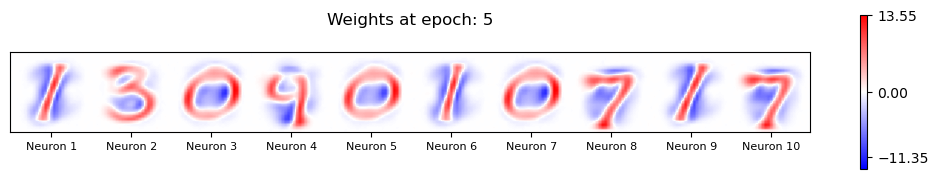

In [3]:


# load data
# data_np = np.loadtxt("gratings.csv", delimiter=",")
# data = torch.from_numpy(data_np)
# n_samples, n_in = data.shape

from sklearn.datasets import fetch_openml
data, y = fetch_openml(name='mnist_784', version=1, data_id=None, return_X_y=True)
data = torch.tensor(data.to_numpy(), dtype=torch.float64)
data /= 255.
data -= torch.mean(data, dim=0) # balance data around mean 
# for mnist eps=0.001 !


# preprocess


print(data.shape)
n_samples, n_in = data.shape

# hps #
n_epochs = 5
n_units = 10
batch_size = 100
tau_th = 0.05
tau_w = 0.001

model = BCM_Model_Curti(n_in, n_units)

# learning loop
for epoch in range(n_epochs):

    data = data[torch.randperm(n_samples)]  # Shuffle the input data

    # Iterate over all minibatches
    for i in range(n_samples // batch_size):
        minibatch = data[i * batch_size:(i + 1) * batch_size].T # transform to shape (n_in, batch_size)
        model.update(minibatch, tau_th=tau_th, tau_w=tau_w)
    draw_weights(model.weights, epoch)



w tensor([[-0.0643, -0.3542, -0.5039,  ..., -0.2344, -0.0632, -0.1289],
        [-0.0332, -0.1852, -0.2434,  ..., -0.1407, -0.1136, -0.1366],
        [ 0.0806, -0.3608, -0.5883,  ..., -0.1714, -0.3053, -0.3592],
        ...,
        [ 0.0761, -0.3854, -0.5753,  ..., -0.0291, -0.1668, -0.1485],
        [ 0.0361, -0.4237, -0.6689,  ..., -0.6348, -0.5359, -0.3048],
        [-0.0223, -0.2651, -0.4368,  ..., -0.2321, -0.1170, -0.2172]],
       dtype=torch.float64)
torch.Size([10, 100])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)
w tensor([[-0.0643, -0.3542, -0.5039,  ..., -0.2344, -0.0632, -0.1289],
        [-0.0332, -0.1852, -0.2434,  ..., -0.1407, -0.1136, -0.1366],
        [ 0.0806, -0.3608, -0.5883,  ..., -0.1714, -0.3053, -0.3592],
        ...,
        [ 0.0761, -0.3854, -0.5753,  ..., -0.0291, -0.1668, -0.1485],
        [ 0.0361, -0.4237, -0.6689,  ..., -0.6348, -0.5359, -0.3048],
        [-0.0223, -0.2651, -0.4368,  ..., -0.2321, -0.1170, -0.2172]],
       d

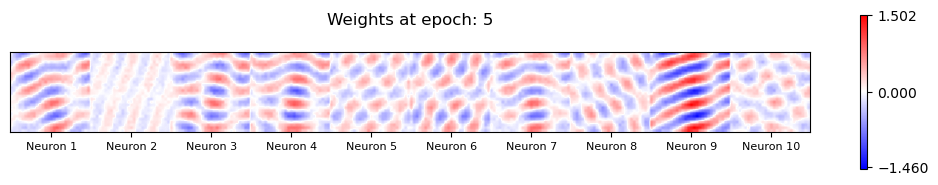

In [24]:


# load data
data_np = np.loadtxt("gratings.csv", delimiter=",")
data = torch.from_numpy(data_np)
n_samples, n_in = data.shape

# from sklearn.datasets import fetch_openml
# data, y = fetch_openml(name='mnist_784', version=1, data_id=None, return_X_y=True)
# data = torch.tensor(data.to_numpy(), dtype=torch.float64)
# data /= 255.
# data -= torch.mean(data, dim=0) # balance data around mean 
# # for mnist eps=0.001 !


# preprocess


print(data.shape)
n_samples, n_in = data.shape

# hps #
n_epochs = 5
n_units = 10
batch_size = 100
tau_th = 0.1
tau_w = 0.05

model = BCM_Model_Curti(n_in, n_units)

# learning loop
for epoch in range(n_epochs):

    data = data[torch.randperm(n_samples)]  # Shuffle the input data

    # Iterate over all minibatches
    for i in range(n_samples // batch_size):
        minibatch = data[i * batch_size:(i + 1) * batch_size].T # transform to shape (n_in, batch_size)
        model.update(minibatch, tau_th=tau_th, tau_w=tau_w)
    draw_weights(model.weights, epoch)



w tensor([[-0.0644,  0.1516,  0.0601,  ...,  0.0232,  0.1422,  0.1491],
        [-0.0353,  0.1051,  0.1429,  ...,  0.2142,  0.2447,  0.0712],
        [ 0.0053,  0.1423,  0.1645,  ...,  0.2024,  0.1160,  0.1473],
        ...,
        [-0.0250,  0.0964,  0.3117,  ...,  0.2870,  0.1909,  0.0718],
        [-0.0197,  0.1945,  0.2319,  ..., -0.0846, -0.1369, -0.1581],
        [-0.0389,  0.1384,  0.1306,  ..., -0.1494, -0.2108, -0.3555]],
       dtype=torch.float64)
torch.Size([10, 100])
tensor([11.4453, 11.4635, 11.7755, 11.5893, 11.0438, 13.9241,  9.4927, 11.5098,
         9.3632,  8.7235], dtype=torch.float64)
w tensor([[-0.0644,  0.1532,  0.0633,  ...,  0.0256,  0.1462,  0.1543],
        [-0.0353,  0.1104,  0.1510,  ...,  0.2218,  0.2525,  0.0754],
        [ 0.0053,  0.1468,  0.1713,  ...,  0.2086,  0.1227,  0.1511],
        ...,
        [-0.0250,  0.1019,  0.3199,  ...,  0.2947,  0.1989,  0.0762],
        [-0.0197,  0.2002,  0.2416,  ..., -0.0908, -0.1468, -0.1689],
        [-0.0389,  0.

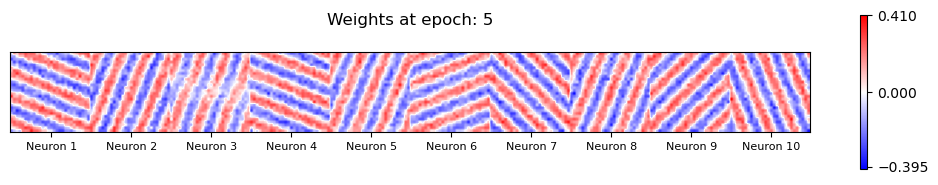

In [27]:


# load data
data_np = np.loadtxt("gratings.csv", delimiter=",")
data = torch.from_numpy(data_np)
n_samples, n_in = data.shape

# from sklearn.datasets import fetch_openml
# data, y = fetch_openml(name='mnist_784', version=1, data_id=None, return_X_y=True)
# data = torch.tensor(data.to_numpy(), dtype=torch.float64)
# data /= 255.
# data -= torch.mean(data, dim=0) # balance data around mean 
# for mnist eps=0.001 !


# preprocess


print(data.shape)
n_samples, n_in = data.shape

# hps #
n_epochs = 5

#n_epochs = 10
n_units = 10
batch_size = 100
#tau_th = 0.09
tau_th = 0.1
tau_w = 0.001

model = BCM_Model_Curti(n_in, n_units)

# learning loop
for epoch in range(n_epochs):

    data = data[torch.randperm(n_samples)]  # Shuffle the input data

    # Iterate over all minibatches
    for i in range(n_samples // batch_size):
        minibatch = data[i * batch_size:(i + 1) * batch_size].T # transform to shape (n_in, batch_size)
        model.update(minibatch, tau_th=tau_th, tau_w=tau_w)
    draw_weights(model.weights, epoch)



### Visual Analysis

#### Selectivity

In [6]:
sel = np.array(model.selectivity)
sel =sel.T

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

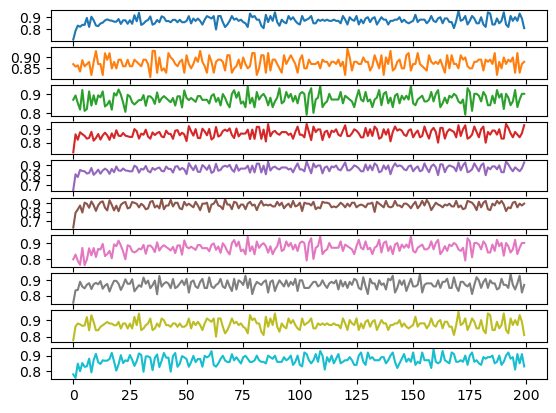

In [7]:
import pandas as pd
sel_df = pd.DataFrame({f'neuron_{i}': sel[i,:] for i in range(n_units)})
sel_df.plot(subplots=True, legend=False)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

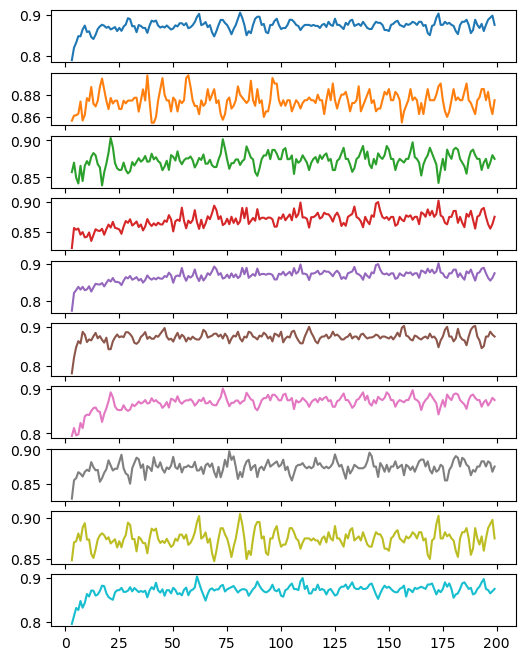

In [8]:
window_size = n_samples // batch_size  # adjust as needed

sel_df = pd.DataFrame({f'neuron_{i}': pd.Series(sel[i,:]).rolling(window=window_size).mean() for i in range(n_units)})
sel_df.plot(subplots=True, legend=False, figsize=(6, n_units-2))


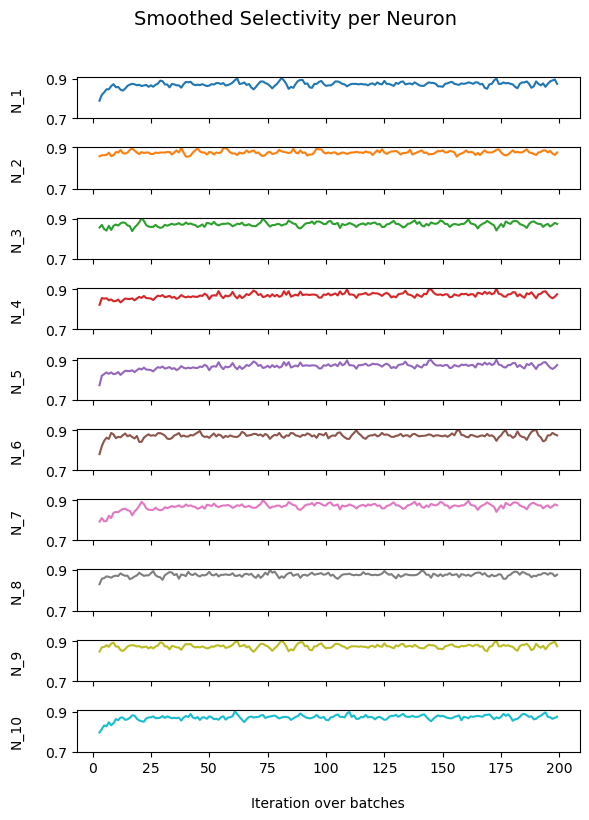

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

window_size = n_samples // batch_size  # adjust as needed

# Smooth and create dataframe
sel_df = pd.DataFrame({f'neuron_{i}': pd.Series(sel[i,:]).rolling(window=window_size).mean() for i in range(n_units)})

# Create subplots
axes = sel_df.plot(subplots=True, legend=False, figsize=(6, n_units-2), title='Smoothed Selectivity per Neuron')

custom_yticks = [0.70, 0.90]


# Loop over axes to set y-labels cleanly
for i, ax in enumerate(axes):
    ax.set_ylabel(f'N_{i+1}', rotation=90, labelpad=20, va='center')
    #ax.yaxis.set_label_position("left")

        # Format y-tick labels to round to 2 decimals
    ax.set_yticks(custom_yticks)
    # y_ticks = ax.get_yticks()
    # ax.set_yticklabels([f"{tick:.2f}" for tick in y_ticks])

ax.set_xlabel(f'Iteration over batches', rotation=0, labelpad=20, va='center')

# Set a single super-title if you prefer
plt.suptitle('Smoothed Selectivity per Neuron', fontsize=14, y=1.02)

plt.tight_layout()
plt.show()


In [ ]:
## OI

import numpy as np

# Example: responses is a 1D array of neuron responses at each orientation
responses = np.array([0.1, 0.5, 1.2, 0.6, 0.2, 0.05])  # example data
orientations = np.linspace(0, 150, len(responses))  # e.g. [0,30,60,90,120,150]

# Find preferred orientation
pref_idx = np.argmax(responses)
pref_resp = responses[pref_idx]

# Find orthogonal orientation index (±90°)
orth_orientation = (orientations[pref_idx] + 90) % 180
# Find closest orientation in your stimulus set
orth_idx = (np.abs(orientations - orth_orientation)).argmin()
orth_resp = responses[orth_idx]

# Calculate OSI
osi = (pref_resp - orth_resp) / (pref_resp + orth_resp)
print("OSI:", osi)


#### Threshold

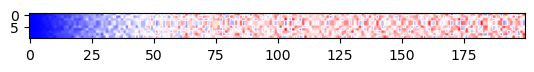

In [10]:
t = np.array(model.threshold_trace)
t = t.T
plt.imshow(t,cmap='bwr')

In [11]:
t.shape

(10, 200)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

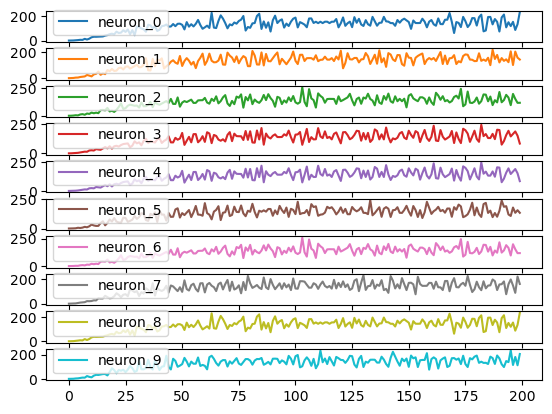

In [12]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i}': t[i, :] for i in range(n_units)})
df.plot(subplots=True)

#### Activations

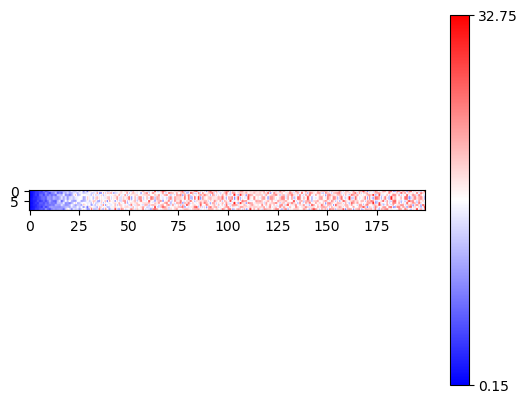

In [13]:
y = np.array(model.activations)
y = y.T
plt.imshow(y,cmap='bwr')
plt.colorbar( ticks=[np.amin(y), 0, np.amax(y)])

In [14]:
y.shape

(10, 200)

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

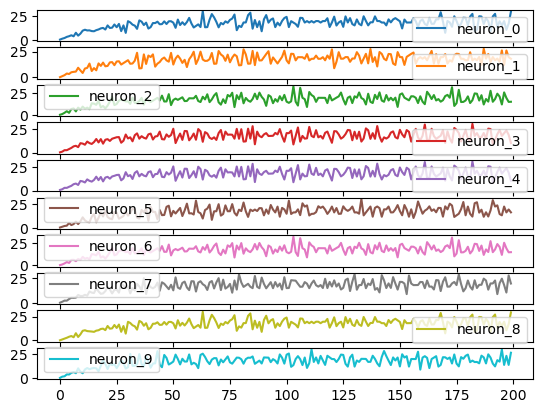

In [15]:
import pandas as pd
df = pd.DataFrame({f'neuron_{i}': y[i, :] for i in range(n_units)})
df.plot(subplots=True)

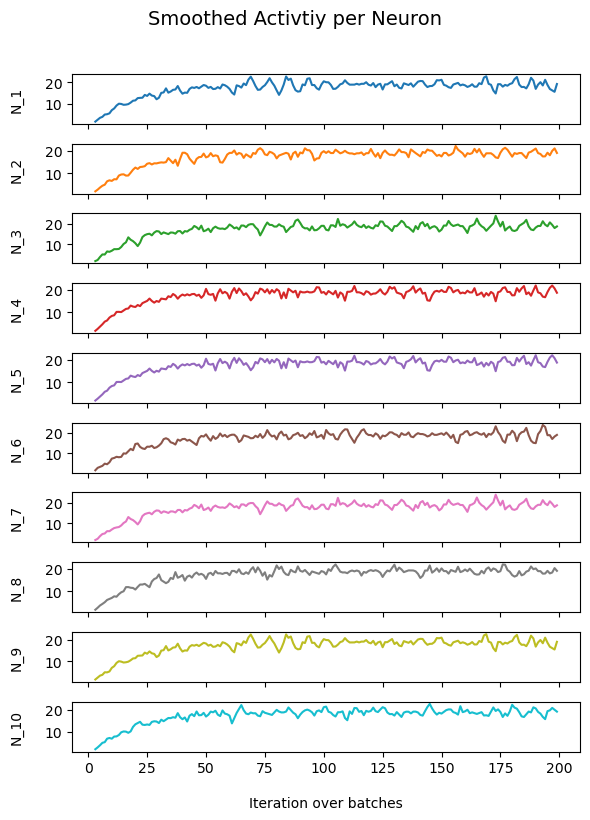

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

window_size = n_samples // batch_size  # adjust as needed

# Smooth and create dataframe
act_df = pd.DataFrame({f'neuron_{i}': pd.Series(y[i,:]).rolling(window=window_size).mean() for i in range(n_units)})

# Create subplots
axes = act_df.plot(subplots=True, legend=False, figsize=(6, n_units-2), title='Smoothed Selectivity per Neuron')

custom_yticks = [10, 20]


# Loop over axes to set y-labels cleanly
for i, ax in enumerate(axes):
    ax.set_ylabel(f'N_{i+1}', rotation=90, labelpad=20, va='center')
    #ax.yaxis.set_label_position("left")

        # Format y-tick labels to round to 2 decimals
    ax.set_yticks(custom_yticks)
    # y_ticks = ax.get_yticks()
    # ax.set_yticklabels([f"{tick:.2f}" for tick in y_ticks])

ax.set_xlabel(f'Iteration over batches', rotation=0, labelpad=20, va='center')

# Set a single super-title if you prefer
plt.suptitle('Smoothed Activtiy per Neuron', fontsize=14, y=1.02)

plt.tight_layout()
plt.show()


#### Comparing Threshold & Activity 

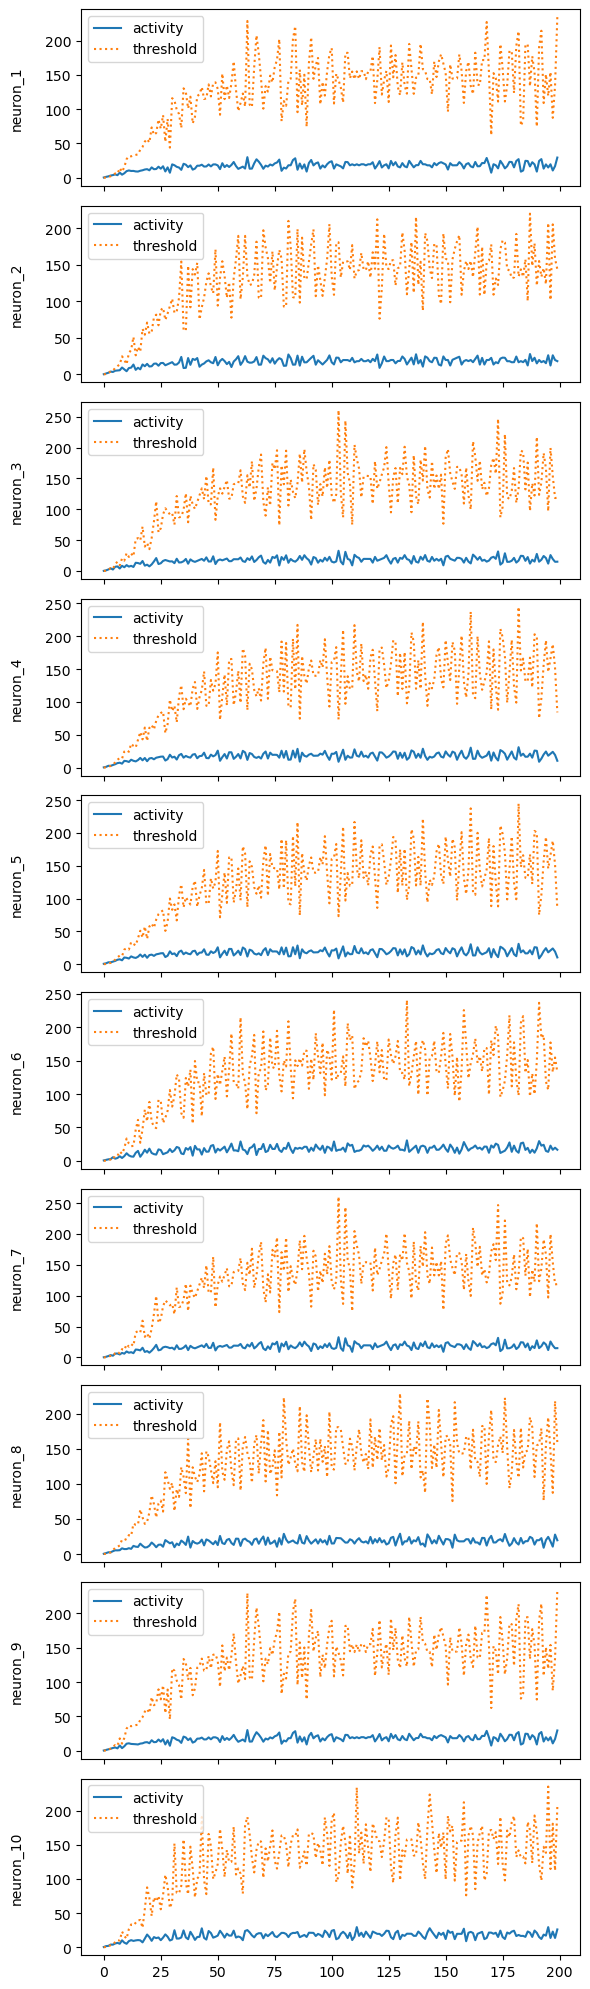

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming y and t are numpy arrays of shape (n_units, timepoints)
n_units = y.shape[0]

# Create subplots
fig, axes = plt.subplots(n_units, 1, figsize=(6, n_units*2), sharex=True)

# Loop over neurons
for i in range(n_units):
    ax = axes[i]
    
    # Plot activity
    ax.plot(y[i, :], label='activity')
    
    # Plot threshold (dotted)
    ax.plot(t[i, :], linestyle=':', label='threshold')
    
    # Set y-label as neuron label
    ax.set_ylabel(f'neuron_{i+1}', rotation=90, labelpad=20, va='center')
    
    # Optionally remove legend if labels are clear
    ax.legend()

plt.tight_layout()
plt.show()


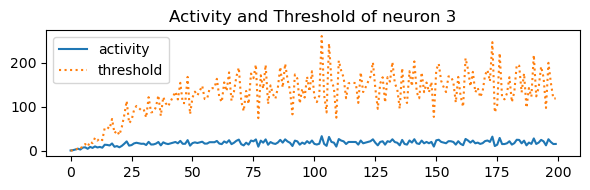

In [18]:
import matplotlib.pyplot as plt

# Select neuron index 5 (6th neuron)
i = 2

fig, ax = plt.subplots(figsize=(6, 2))

# Plot activity
ax.plot(y[i, :], label='activity')

# Plot threshold (dotted)
ax.plot(t[i, :], linestyle=':', label='threshold')

# Set y-label as neuron label
#x.set_ylabel(f'neuron_{i}', rotation=0, labelpad=40, va='center')
plt.title(f"Activity and Threshold of neuron {i+1}")
# Add legend
ax.legend()

plt.tight_layout()
plt.show()


In [19]:
import seaborn as sns

In [20]:
y.shape

(10, 200)

In [21]:
y[i,:]

array([ 0.14799515,  0.948522  ,  2.40772407,  4.21933429,  2.33026481,
        6.7717377 ,  7.35363292,  3.9899091 ,  8.33851895,  6.02234318,
        9.46367939,  7.04568473,  8.28600412,  6.48446426, 13.26482429,
       12.84420037, 11.53714152, 16.14638778,  8.60380007, 10.15898928,
        7.46331996, 10.60449089, 15.3908997 , 20.88924679, 11.21628924,
       12.46038338, 16.25842158, 17.74111133, 16.55644986, 15.37692618,
       15.58965623, 12.62154186, 19.79664689, 13.72263957, 13.97114257,
       15.74684993, 19.45422499, 11.74445897, 18.75101185, 16.06970565,
       14.73570416, 16.35510793, 17.85270664, 19.50399189, 16.52031839,
       22.03228914, 15.30926343, 15.40460978, 23.74198831, 11.19065203,
       17.01509821, 18.64221718, 17.18743088, 18.61658931, 20.14583832,
       15.79200858, 15.93255207, 19.04845474, 18.92984591, 18.94843106,
       21.83434697, 15.88819251, 14.69557864, 20.74113213, 17.71443277,
       23.58196872, 14.59264871, 17.7135644 , 22.20578176, 24.93

In [22]:
t[i,:]

array([6.57584084e-03, 3.47941685e-01, 1.85736281e+00, 4.63523287e+00,
       3.23889284e+00, 1.16283435e+01, 1.48051249e+01, 9.11146513e+00,
       2.03579186e+01, 1.67597345e+01, 2.89353187e+01, 2.27760625e+01,
       2.81505991e+01, 2.36623686e+01, 5.17876426e+01, 5.32630495e+01,
       4.94226065e+01, 7.19409622e+01, 3.95019186e+01, 4.55271879e+01,
       3.53167679e+01, 5.34798619e+01, 8.02932290e+01, 1.12880910e+02,
       6.25315646e+01, 6.91567592e+01, 9.17856640e+01, 1.01565819e+02,
       9.68124673e+01, 9.16860635e+01, 9.37529858e+01, 7.51136404e+01,
       1.21434266e+02, 8.69636531e+01, 8.80173905e+01, 9.88976235e+01,
       1.25963717e+02, 7.89782899e+01, 1.21940002e+02, 1.07913112e+02,
       1.00524387e+02, 1.11591221e+02, 1.23130082e+02, 1.33958154e+02,
       1.16284003e+02, 1.54139541e+02, 1.08211974e+02, 1.08068650e+02,
       1.67642762e+02, 8.29485329e+01, 1.20573765e+02, 1.34009116e+02,
       1.25379703e+02, 1.36292760e+02, 1.47374912e+02, 1.17327615e+02,
      

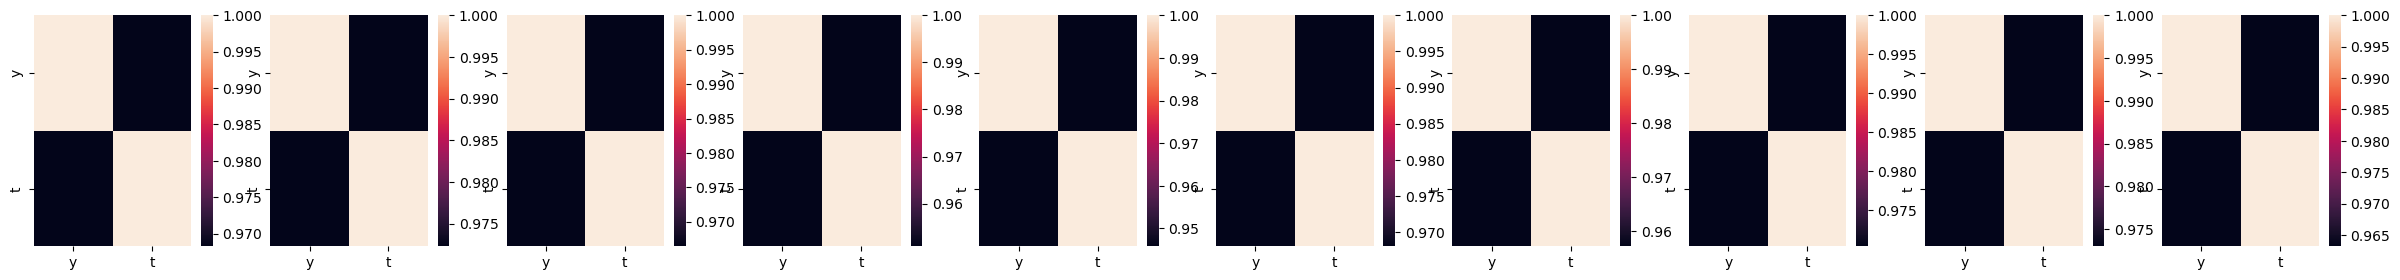

In [23]:
n_cols = n_units  # number of columns in subplot grid
n_rows = 1 # compute number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i in range(n_units):
    df = pd.DataFrame({'y':y[i,:], 't':t[i,:]})
    cor = df.corr()
    sns.heatmap(cor, ax= axes[i])